In [3]:
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

/home/henry/venv-ardupilot/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Configuration of Motor Allocation Matrix

$$ \begin{bmatrix}
T \\
T_{\phi} \\
T_{\theta} \\
T_{\psi}
\end{bmatrix} =
\begin{bmatrix}
k_{t} & k_{t} & k_{t} & k_{t} \\
L\cos{\beta}k_{t} & L\cos{\beta}k_{t} & L\cos{\beta}k_{t} & L\cos{\beta}k_{t} \\
L\sin{\beta}k_{t} & L\sin{\beta}k_{t} & L\sin{\beta}k_{t} & L\sin{\beta}k_{t} \\
k_{w} & k_{w} & -k_{w} & -k_{w}
\end{bmatrix}
\begin{bmatrix}
\omega^{2}_{0} \\
\omega^{2}_{1} \\
\omega^{2}_{2} \\
\omega^{2}_{3} \\
\end{bmatrix}
$$
Or equivalent with lengths and signs
$$ \begin{bmatrix}
T \\
T_{\phi} \\
T_{\theta} \\
T_{\psi}
\end{bmatrix} =
\begin{bmatrix}
k_{t} & k_{t} & k_{t} & k_{t} \\
-L_{y}k_{t} & L_{y}k_{t} & -L_{y}k_{t} & L_{y}k_{t} \\
L_{x}k_{t} & -L_{x}k_{t} & -L_{x}k_{t} & L_{x}k_{t} \\
k_{w} & k_{w} & -k_{w} & -k_{w}
\end{bmatrix}
\begin{bmatrix}
\omega^{2}_{0} \\
\omega^{2}_{1} \\
\omega^{2}_{2} \\
\omega^{2}_{3} \\
\end{bmatrix}
$$

This assumes NED-body frame with $\beta$ increasing from the positive y-axis (where $\beta=0$) to the positive x-axis

### Assumptions
Standard model of thrust:
$$F_{i}=k_{t}\omega^{2}$$

$$k_{t}=\frac{1}{4\omega^{2}}m(a+g)$$
With $k_{t}$=2.05e-6, for hover thrust (a=0), we need the following rotor speed

In [4]:
m = 1  # kg
g = 9.8  # m/s^2
Ix, Iy, Iz = 0.11, 0.11, 0.04  # kg m^2
l = 0.2  # m (this drops out when controlling via torques)

In [5]:
l = math.sqrt(0.13*0.13+0.2*0.2)
ang_rad = math.atan(0.2/0.13)
print("RAD",ang_rad)
print("DEG",ang_rad*180/math.pi)

RAD 0.9944211062037129
DEG 56.97613244420336


In [15]:
m=2.23
g=9.8
ylen = 0.13
xlen = 0.2
kt = 2.05e-6
km = 0.02*kt
preinv = np.array([[kt, kt, kt, kt],
                  [-ylen*kt, ylen*kt, -ylen*kt, ylen*kt],
                  [xlen*kt, -xlen*kt, -xlen*kt, xlen*kt],
                  [km, km, -km, -km]])

allocation = np.linalg.pinv(preinv)
print(allocation)

[[  121951.2195122   -938086.30393996   609756.09756098  6097560.97560975]
 [  121951.2195122    938086.30393996  -609756.09756098  6097560.97560976]
 [  121951.2195122   -938086.30393996  -609756.09756098 -6097560.97560975]
 [  121951.2195122    938086.30393996   609756.09756098 -6097560.97560976]]


In [16]:
## According to gazebo sim, max RPM is 838 which is ~87.7 rad/s

## With a kt of 1.5e-6, that gives a max force of
F_max = kt*(87.7*87.7)
print(F_max*4)

0.063068578


### Estimating $k_{t}$
In simulation, we observe an acceleration of 3.5m/s2 with all four motors at a speed of 1900 rad/s and with a mass of 2.23kg. Hovering occurs at $a=0$ for which we can compute the required rotor speed $\omega$
$$\omega=\sqrt{\frac{1}{4k_{t}}m(a+g)}$$

In [17]:
## In order to try and identify the maximum thrust generated with a max PWM signal (1900), we set all outputs to 1900PWM

zvel_delta = 1.75
sec_delta = 0.5
accel_est = zvel_delta/sec_delta
mass=2.23 ## including gimbal
PWM=1900

kt_est = 0.25*(1/(PWM*PWM))*mass*(9.8+3.5)
print(f'Estimated kt: {kt_est}')

Estimated kt: 2.0539473684210527e-06


In [18]:
hover_w = math.sqrt((1/(4*kt_est))*mass*(0+g))
print(hover_w)

1630.9506430300091


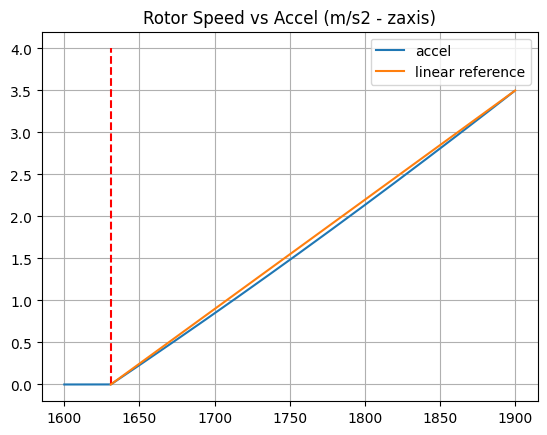

In [19]:
## Graph of rotor speed and acceleration

x = [i for i in range(1600,1900)]
y = [max(0,4*kt_est*i*i*(1/mass)-9.8) for i in range(1600,1900)]
plt.plot(x,y, label=('accel'))
plt.grid(True)
plt.title('Rotor Speed vs Accel (m/s2 - zaxis)')
plt.vlines(hover_w,0,4, color='red', linestyle='--')
plt.plot([hover_w,1900],[0,3.5], label='linear reference')
plt.legend()
plt.show()

### Allocation matrix scenarios
Different motor/rotor speeds for certain scenarios

$$
\begin{bmatrix}
\omega^{2}_{0} \\
\omega^{2}_{1} \\
\omega^{2}_{2} \\
\omega^{2}_{3} \\
\end{bmatrix} =
T_\text{Allocation}^{-1}
\begin{bmatrix}
T \\
T_{\phi} \\
T_{\theta} \\
T_{\psi}
\end{bmatrix}
$$


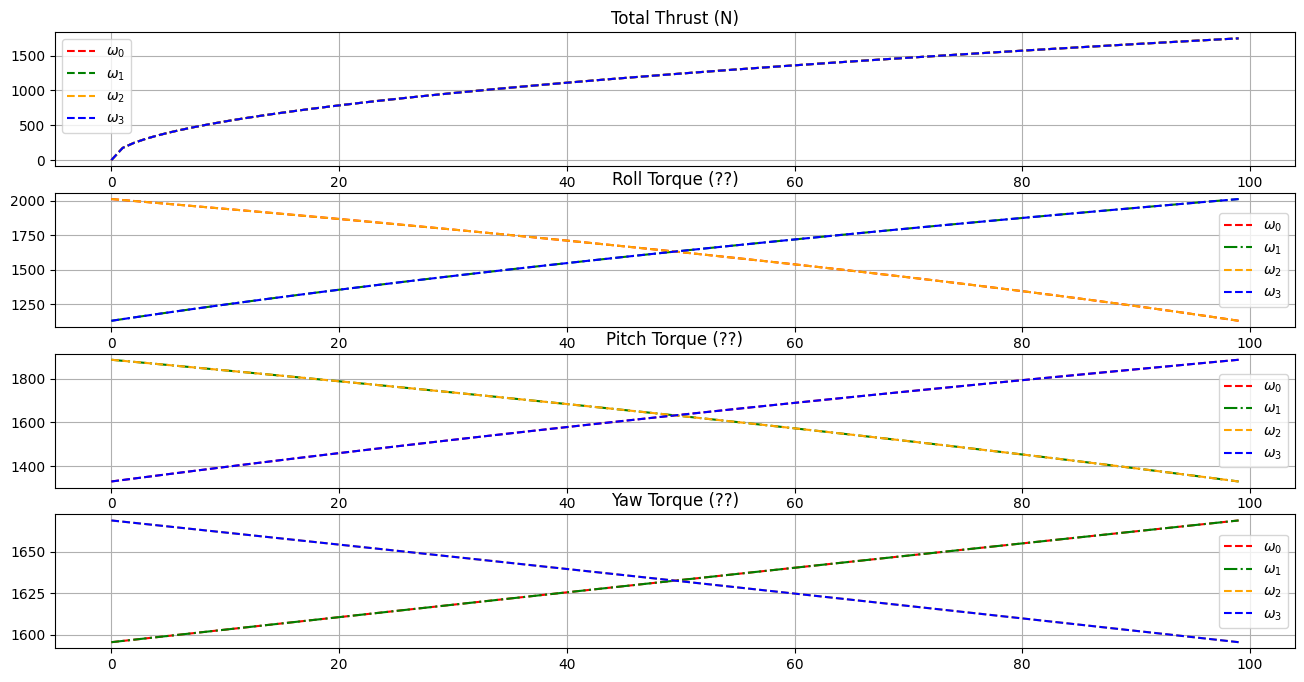

In [20]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(4,1, figure=fig)

## Scenario 1 - Thrust from 0 to mg to 25N
ctl = np.array([1, 0, 0, 0]).reshape((4,1))@np.linspace(0,25,100).reshape((1,100))
out = allocation@ctl

ax = fig.add_subplot(gs[0,0])
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][0]), color='red', linestyle='--', label=r'$\omega_{0}$')
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][1]), color='green', linestyle='--', label=r'$\omega_{1}$')
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][2]), color='orange', linestyle='--', label=r'$\omega_{2}$')
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][3]), color='blue', linestyle='--', label=r'$\omega_{3}$')
ax.set_title(f'Total Thrust (N)')
ax.legend()
ax.grid(True)

## Scenario 2 - Roll Torque from [-1.475, 1.475] with mg thrust (hover)
ctl = np.array([0, 1, 0, 0]).reshape((4,1))@np.linspace(-1.475,1.475,100).reshape((1,100))
ctl[0,:] = mass*9.8
out = allocation@ctl

ax = fig.add_subplot(gs[1,0])
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][0]), color='red', linestyle='--', label=r'$\omega_{0}$')
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][1]), color='green', linestyle='dashdot', label=r'$\omega_{1}$')
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][2]), color='orange', linestyle='--', label=r'$\omega_{2}$')
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][3]), color='blue', linestyle='--', label=r'$\omega_{3}$')
ax.set_title(f'Roll Torque (??)')
ax.legend()
ax.grid(True)

## Scenario 3 - Pitch Torque from [-1.475, 1.475] with mg thrust (hover)
ctl = np.array([0, 0, 1, 0]).reshape((4,1))@np.linspace(-1.475,1.475,100).reshape((1,100))
ctl[0,:] = mass*9.8
out = allocation@ctl

ax = fig.add_subplot(gs[2,0])
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][0]), color='red', linestyle='--', label=r'$\omega_{0}$')
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][1]), color='green', linestyle='dashdot', label=r'$\omega_{1}$')
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][2]), color='orange', linestyle='--', label=r'$\omega_{2}$')
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][3]), color='blue', linestyle='--', label=r'$\omega_{3}$')
ax.set_title(f'Pitch Torque (??)')
ax.legend()
ax.grid(True)

## Scenario 4 - Pitch Torque from [-0.0196, 0.0196] with mg thrust (hover)
ctl = np.array([0, 0, 0, 1]).reshape((4,1))@np.linspace(-0.0196,0.0196,100).reshape((1,100))
ctl[0,:] = mass*9.8
out = allocation@ctl

ax = fig.add_subplot(gs[3,0])
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][0]), color='red', linestyle='--', label=r'$\omega_{0}$')
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][1]), color='green', linestyle='dashdot', label=r'$\omega_{1}$')
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][2]), color='orange', linestyle='--', label=r'$\omega_{2}$')
ax.plot(list(range(0,100)), np.vectorize(lambda x: math.sqrt(x))(out[:][3]), color='blue', linestyle='--', label=r'$\omega_{3}$')
ax.set_title(f'Yaw Torque (??)')
ax.legend()
ax.grid(True)



In [46]:
np.linspace(0,25,100).reshape(100,1).shape

(100, 1)